In [1]:
#Import the basics
import numpy as np
import yaml
import matplotlib.pyplot as plt

#Import hardware classes
from pyRTC.hardware.OOPAOInterface import OOPAOInterface
from pyRTC.SlopesProcess import SlopesProcess
from pyRTC.Pipeline import *
from pyRTC.Loop import Loop

import time



======================================================================================>      
   ✸       *           °                *      *                                            
        °   ✸           ▄███▄   ▄███▄  ▄████▄   ▄███▄ * ▄███▄    =>               ▄▄▄▄           
  ✸            °       ██*  ██ ██   ██ ██   ██ ██   ██ ██   ██   ====>         ▄█▀▀  ▀▀█▄        
   *   °    ✸          ██   ██ ██ ° ██ ██   ██ ██ * ██ ██   ██   ==>          █▀ ▄█▀▀█▄ ▀█       
✸    *             °   ██   ██ ██   ██ █████▀  ██▄▄▄██ ██   ██   =========>  █▀ █▀ ▄▄ ▀█ ▀█      
           ✸   °       ██ * ██ ██   ██ ██      ██▀▀▀██ ██   ██   ========>   █▄ █▄ ▀▀ ▄█ ▄█      
 *    ✸     °          ██   ██ ██   ██ ██  *   ██   ██ ██*  ██   =>           █▄ ▀█▄▄█▀ ▄█       
    °        *    ✸     ▀███▀   ▀███▀  ██    ° ██   ██  ▀███▀    ==>           ▀█▄▄  ▄▄█▀        
         ✸       *          *         *                                           ▀▀▀▀           
===========================

In [2]:
"""
Shared memory in python is a bit annoying, we are required to unlink it from the garbage collector
so that it will stick around in between runs, however sometime you can get into a situation where 
the SHM is not intialized properly. Usually you will see an error like: 
TypeError: buffer is too small for requested array

To reset a SHM you can run the following code. Note: it will throw some garbage collector errors.
"""
# shm_names = ["wfs", "wfsRaw", "wfc", "wfc2D", "signal", "signal2D"] #list of SHMs to reset
# clear_shms(shm_names)

'\nShared memory in python is a bit annoying, we are required to unlink it from the garbage collector\nso that it will stick around in between runs, however sometime you can get into a situation where \nthe SHM is not intialized properly. Usually you will see an error like: \nTypeError: buffer is too small for requested array\n\nTo reset a SHM you can run the following code. Note: it will throw some garbage collector errors.\n'

In [3]:
# Load the configuration file
def read_yaml_file(file_path):
    with open(file_path, 'r') as file:
        conf = yaml.safe_load(file)
    return conf

#Now we can read our YAML config file 
conf = read_yaml_file("simple_OOPAO_config.yaml")

#And separate it into sections for each of our AO loop components
confLoop = conf["loop"]
confWFS = conf["wfs"]
confWFC = conf["wfc"]
confPSF = conf["psf"]
confSlopes = conf["slopes"]

print(confLoop)
print(confWFS)
print(confWFC)
print(confPSF)
print(confSlopes)

{'gain': 0.1, 'numDroppedModes': 0, 'pokeAmp': 1e-06, 'numItersIM': 10, 'affinity': 2, 'method': 'push-pull', 'functions': ['standardIntegrator']}
{'name': 'OOPAOWFS', 'width': 32, 'height': 32, 'darkCount': 10, 'affinity': 3, 'functions': ['expose']}
{'name': 'OOPAOWFC', 'numActuators': 21, 'numModes': 21, 'flatFile': '', 'saveFile': 'flat.npy', 'm2cFile': '', 'affinity': 3, 'commandCap': 0.8, 'hardwareDelay': 0.1, 'frameDelay': 0, 'functions': ['sendToHardware']}
{'name': 'OOPAOPSF', 'index': 0, 'width': 54, 'height': 54, 'darkCount': 1000, 'integration': 100, 'affinity': 3, 'functions': ['expose']}
{'type': 'SHWFS', 'signalType': 'slopes', 'affinity': 4, 'refSlopesFile': '', 'validSubApsFile': '', 'subApSpacing': 8, 'subApOffsetX': 0, 'subApOffsetY': 0, 'functions': ['computeSignal']}


In [4]:
from simpleParamFile import *
param = initializeParameterFile()

Reading/Writting calibration data from data_calibration/
Writting output data in data_cl/


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Diameter             1                [m]        
    Resolution            32             [pixels]     
    Pixel Size           0.03              [m]        
     Surface             1.0               [m2]       
Central Obstruction       0.0         [% of diameter]  
Pixels in the pupil       812             [pixels]     
      Source             None                         
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
No light propagated through the telescope
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Diameter             1                [m]        
    Resolution            32             [pixels]     
    Pixel Size           0.03              [m]        
     Surface             1.0               [m2]       
Central Obstruction       0.0         [% of diameter]  
Pixels in the pupil       812             [pixels]     
      Source         

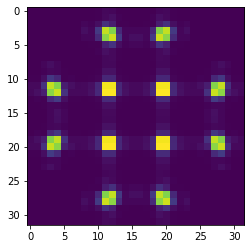

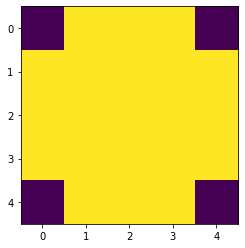

NUM VALID ACT: 21


In [5]:
"""
Create the OOPAO simulation interface object 
Running this cell will initialize the dm, wfs, psf, and slopes objects, 
but will not start their real time computations. This inialization includes
the creation of the Shared Memory Objects, and the simulation inialization.
"""
sim = OOPAOInterface(conf=conf, param=param)
wfs, dm, psf = sim.get_hardware()

plt.imshow(wfs.wfs.cam.frame)
plt.show()

plt.imshow(dm.layout)
plt.show()

print(f"NUM VALID ACT: {np.sum(dm.layout)}")

In [7]:
"""
It's important to set the full basis and number of possible modes before
initializing the loop object. Here I define a KL basis for the system
"""
from OOPAO.calibration.compute_KL_modal_basis import compute_KL_basis

NUM_MODES = 21

M2C_KL = compute_KL_basis(sim.tel, sim.atm, sim.dm)
dm.setM2C(M2C_KL[:,:NUM_MODES])

"""
"""
slopes = SlopesProcess(conf=conf)

""" 
"""
#Initialize our AO loop object
loop = Loop(conf=conf)

COMPUTING TEL*DM...
 
PREPARING IF_2D...
 
Computing Specific Modes ...
 
COMPUTING VON KARMAN 2D PSD...
 
COMPUTING COV MAT HHt...
 
TIME ELAPSED: 0 sec. COMPLETED: 100 %
SERIALIZING IFs...
 
SERIALIZING Specific Modes...
 
COMPUTING IFs CROSS PRODUCT...
 
NMAX =  17
RMS opd error = [[1.69814834e-08 6.46646817e-08 6.46646817e-08]]
RMS Positions = [[1.75602688e-07 5.60200196e-07 5.60200196e-07]]
MAX Positions = [[6.19665037e-07 9.99272119e-07 9.99272119e-07]]
CHECKING ORTHONORMALITY OF SPECIFIC MODES...
 
Orthonormality error for SpM =  4.440892098500626e-16
BUILDING SEED BASIS ...
 
Orthonormality error for 16 modes of the Seed Basis =  1.3322676295501878e-14
KL WITH DOUBLE DIAGONALISATION: COVARIANCE ERROR =  2.9643839652876435e-14
Orthonormality error for 16 modes of the KL Basis =  1.176836406102666e-14
Piston removed from the modal basis!
Closing wfc
Opening Existing Shared Memory Object wfc
Opening Existing Shared Memory Object wfc_meta
Opening Existing Shared Memory Object wfs_m

In [8]:
"""
Start the processes. Here the real-time computations selected in
the config will begin.
"""
dm.start()
dm.flatten()

wfs.start()
slopes.start()

#Take new reference slopes while dm is flat.
time.sleep(1)
slopes.takeRefSlopes()

# print(sim.dm.OPD.shape)
psf.start()

In [9]:
#Remove the atmosphere from the simulation
sim.removeAtmosphere()

loop.pokeAmp = 1e-7

#Compute the IM, blocking
loop.computeIM()

#Add the atmosphere back to the simulation
sim.addAtmosphere()

Telescope and Atmosphere separated!
Telescope and Atmosphere separated!
Telescope and Atmosphere combined!
Telescope and Atmosphere combined!


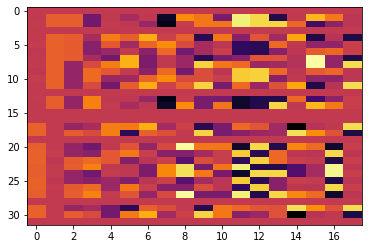

In [10]:
loop.plotIM()

In [13]:
dm.flatten()
time.sleep(1e-2)
loop.setGain(0.3)
loop.start()
time.sleep(10)
loop.stop()
dm.flatten()